In [277]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [278]:
# Здесь загружаются названия референса, файла с ридами (bam), файла с геномами
import argparse

if is_notebook() == False:
    parser = argparse.ArgumentParser(description='Supply reference fasta and bam file')
    parser.add_argument('ref',
                        help='reference fasta')
    parser.add_argument('bam',
                        help='bam file')
    parser.add_argument('cont',
                        help='list of contaminants fasta')


    args = parser.parse_args()
    ref_fname = args.ref
    bam_fname = args.bam
    genomes_fname = args.cont
    
else:
    ref_fname     = 'refchrm.fa'
    bam_fname     = 'simulated_data.bam'
    genomes_fname = 'contaminants.fa'

In [279]:
import os
from collections import Counter
import pysam
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
from scipy.special import binom
import scipy.stats as st
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from multiprocess import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from preprocess import *
from functions import *
os.system('python setup.py build_ext --inplace')
from MN import *

running build_ext
copying build/lib.macosx-11.0-arm64-3.10/MN.cpython-310-darwin.so -> 


In [280]:
def do_mcmc(n_iterations = 50000, output_file='', n_threads=8, model=0, show_each=10):
    if output_file != '':
        res = open(output_file,'w')
    p_list = []
    num_reads, num_genomes  = MC.shape
    print(MC.shape)
    p = np.random.dirichlet([1]*num_genomes)
    # pool = Pool(n_threads)
    for i in tqdm(range(n_iterations) ):
        
        func = lambda x: get_Zi(MC, p, base_err, x)
        
        # Z = np.array(pool.map_async(func, range(num_reads)).get())
        Z = np.array([func(s) for s in range(num_reads) ], dtype = int)
        eta = get_eta(Z, num_genomes)
        if model == 0:
            p0 = np.random.beta(1 + eta[0],1+num_reads-eta[0])
            p_other = np.random.dirichlet(1+ eta[1:])
            p_other *= (1-p0)/p_other.sum()

            p[0] = p0
            p[1:] = p_other
            p_list.append(p[0])
        else:
            p = np.random.dirichlet(1+ eta)
            p_list.append(p[0])
        if output_file != '':
            res.write(f'iteration {i}')
            res.write(str(p[0]))
        if i % show_each == 0:
            # print(p[0], p[1:].sum()) 
            print(p)
    # pool.close()
    if output_file != '':
        res.close()
    return p_list

In [281]:
bam, genomes = preprocess(ref_fname, genomes_fname, bam_fname)

#EXTRACTING MTDNA OK
#CONSENSUS IS READY


[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 2000
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8176 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 5 ambiguous characters.
    1 / 2
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 2
done.

Progressive alignment 1/1... 
STEP     1 / 1 
done.

disttbfast (nuc) Version 7.490
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-1 (Very fast but very rough)
 Progressive method (rough guide tree was used.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this chang

#ALL GENOMES ARE READY
123
#BAM FILE IS READY


rm: simulated_data_mt_ra.sai: No such file or directory


In [282]:
genomes_arr = make_genomes_arr(genomes)

In [283]:
genomes_arr

array([[b'n', b'n', b'n', ..., b'a', b't', b'g'],
       [b'g', b'a', b't', ..., b'a', b't', b'g']], dtype='|S1')

In [284]:
same = get_same(genomes_arr)

In [285]:
genomes0 = (''.join( np.array(genomes_arr, dtype = str)[0])).upper()

In [286]:
aln_coords = get_aln_pos(genomes0)

In [287]:
M, N, base_err = get_MN(genomes_arr, bam, aln_coords, same)

MN tables: 100%|█████████████████████████| 4969/4969 [00:00<00:00, 12775.56it/s]


In [288]:
print(f'#base error is {base_err}')

#base error is 0.00018946341542070956


In [289]:
MC = get_mc(M, N, base_err)

In [290]:
MC

array([[0.98114618, 0.0185922 ],
       [0.97851119, 0.01852781],
       [0.97649887, 0.0184801 ],
       ...,
       [0.98123008, 0.98123008],
       [0.97854883, 0.97854883],
       [0.98123008, 0.98123008]])

In [291]:
# idx = [i for i in range(len(MC)) if not np.all(MC[i]==MC[i,0])]
# MC = MC[idx]

In [292]:
P = do_mcmc(10000, n_threads=1, model=0, show_each=1000)

(4969, 2)


  0%|                                       | 25/10000 [00:00<01:17, 129.30it/s]

[0.53234551 0.46765449]


 10%|███▊                                 | 1031/10000 [00:06<00:51, 173.23it/s]

[0.99188416 0.00811584]


 20%|███████▌                             | 2039/10000 [00:11<00:45, 173.33it/s]

[0.99426753 0.00573247]


 30%|███████████▏                         | 3029/10000 [00:17<00:40, 173.37it/s]

[0.99266939 0.00733061]


 41%|███████████████                      | 4055/10000 [00:23<00:34, 173.30it/s]

[0.99306437 0.00693563]


 50%|██████████████████▋                  | 5045/10000 [00:29<00:28, 171.26it/s]

[0.99570712 0.00429288]


 57%|█████████████████████                | 5696/10000 [00:33<00:25, 171.91it/s]


KeyboardInterrupt: 

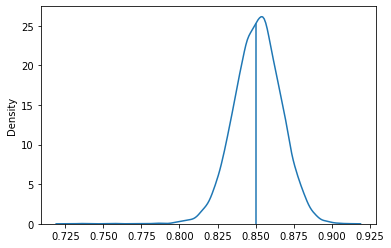

In [293]:
sns.kdeplot(P)
plt.axvline(0.85, 0, 0.92)